In [1]:
# importing required libraries
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

In [2]:
# Checking and creating a directory named 'data' if it doesn't already exist
if not os.path.exists('data'):
    os.mkdir('data')

In [3]:
# Defining a set of image transformations to be applied to the dataset
transform = transforms.Compose([
    transforms.ToTensor(),    # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean = 0.5,
        std = 0.5
    )
])

transform

Compose(
    ToTensor()
    Normalize(mean=0.5, std=0.5)
)

In [4]:
%%capture

# Data preparation for training
fminst_data = torchvision.datasets.FashionMNIST(
    root = 'data/',
    train = True,
    download = True,
    transform = transform
)

In [5]:
# Batch Size
batch_size = 16

# Initializes a DataLoader object to handle the FashionMNIST dataset
fmnist_dl = torch.utils.data.DataLoader(
    fminst_data,
    batch_size = batch_size,
    shuffle = True,
    drop_last = True
)

fmnist_dl

In [6]:
# There are total 60000 training images , so by dividing 60k by batch size , length of dataloader is obtained i.e 60000/16=3750
print(len(fmnist_dl))

3750


In [7]:
# Creates an iterator from the DataLoader `fmnist_dl` which contains batches of data (images and labels).
dataiter = iter(fmnist_dl)

# Retrieves the next batch of images and labels from the iterator.
images, labels = next(dataiter)

print(images.shape, labels.shape)

torch.Size([16, 1, 28, 28]) torch.Size([16])


In [8]:
classes = [
    't_shirt/top',
    'trouser',
    'pullover',
    'dress',
    'coat',
    'sandal',
    'shirt',
    'sneaker',
    'bag',
    'ankle_boots'
]

In [9]:
# This function display a grid of images in a single figure
def display_image_grid(epoch: int, step: int,  images: torch.Tensor, nrow: int):
    images = images / 2 + 0.5

    image_grid = make_grid(images, nrow)     # Images in a grid
    image_grid = image_grid.permute(1, 2, 0) # Move channel last
    image_grid = image_grid.cpu().numpy()    # To Numpy

    plt.imshow(image_grid)

    plt.xticks([])
    plt.yticks([])

    plt.show()
    plt.close()

# This function displays a single image
def display(img):
    img = img / 2 + 0.5

    img = img.permute(1, 2, 0)

    npimg = img.numpy()

    plt.imshow(npimg)
    plt.xticks([])
    plt.yticks([])
    plt.show()

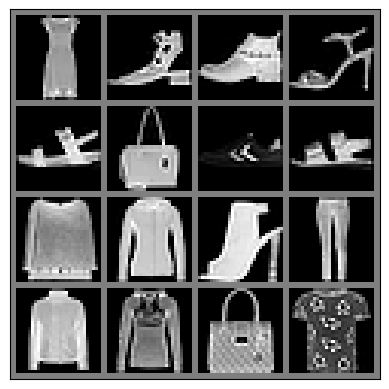

dress
 sandal
 ankle_boots
 sandal
 sandal
 bag  
 sneaker
 sandal
 t_shirt/top
 coat 
 sandal
 trouser
 coat 
 pullover
 bag  
 t_shirt/top



In [10]:
display(make_grid(images, 4)) # show a grid of images

print(' '.join(f'{classes[labels[j]]:5s}\n' for j in range(16))) #printing the class labels

In [11]:
latent_size = 100
image_size = 784 # 28 x 28

In [12]:
# The generator, G, is designed to map the latent space vector (z) to data-space.
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.ReLU(),

            nn.Linear(128, 256),
            nn.ReLU(),

            nn.Linear(256, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

netG = Generator()
print(netG)

Generator(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Tanh()
  )
)


In [13]:
# The discriminator, is a binary classification network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(p = 0.2),

            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(p = 0.2),

            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(p = 0.2),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

netD = Discriminator()
print(netD)

Discriminator(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [14]:
# Binary Cross Entropy loss
criterion = nn.BCELoss()
criterion

BCELoss()

In [15]:
# Creating instance of Generator class
netG = Generator()

# Creating instance of Discriminator class
nedD = Discriminator()

# Learning Rate
lr = 0.0002

# Initializing Adam optimizer both network
d_optimizer = optim.Adam(netD.parameters(), lr = lr)
g_optimizer = optim.Adam(netG.parameters(), lr = lr)

In [16]:
real_label = 1.
fake_label = 0.

In [17]:
# If instead of displaying step wise results, we want to display average epoch wise losses and scores, we can store avg values in separate lists
avg_G_losses = []
avg_D_losses = []
avg_real_score_list = []
avg_fake_score_list = []

num_epochs = 30

fixed_noise = torch.randn(batch_size, 100)

netD.train()
netG.train()

Generator(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Tanh()
  )
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0: |
                      Step: 3749 |
                      D_real Loss: 0.161 |
                      D_fake Loss: 0.243 |
                      D_total Loss: 0.403 |
                      G_Loss: 2.734 |
                      Real_score 0.872 |
                      Fake_score 0.183 |
                      Fake_score_after_D_update: 0.110
            


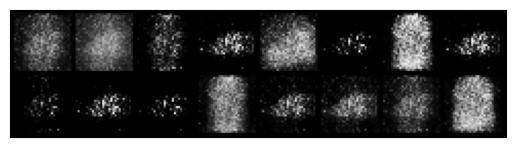

  3%|▎         | 1/30 [00:57<27:39, 57.22s/it]

Epoch 1: |
                      Step: 3749 |
                      D_real Loss: 0.329 |
                      D_fake Loss: 0.320 |
                      D_total Loss: 0.649 |
                      G_Loss: 1.764 |
                      Real_score 0.766 |
                      Fake_score 0.225 |
                      Fake_score_after_D_update: 0.276
            


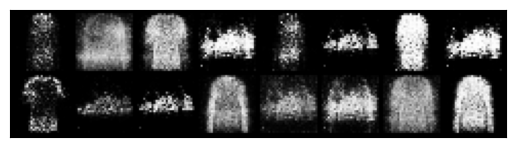

  7%|▋         | 2/30 [01:41<23:10, 49.65s/it]

Epoch 2: |
                      Step: 3749 |
                      D_real Loss: 0.748 |
                      D_fake Loss: 0.313 |
                      D_total Loss: 1.061 |
                      G_Loss: 1.417 |
                      Real_score 0.594 |
                      Fake_score 0.259 |
                      Fake_score_after_D_update: 0.266
            


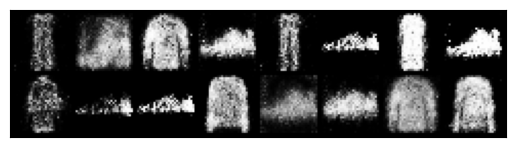

 10%|█         | 3/30 [02:25<21:07, 46.94s/it]

Epoch 3: |
                      Step: 3749 |
                      D_real Loss: 0.356 |
                      D_fake Loss: 0.640 |
                      D_total Loss: 0.996 |
                      G_Loss: 1.097 |
                      Real_score 0.742 |
                      Fake_score 0.371 |
                      Fake_score_after_D_update: 0.396
            


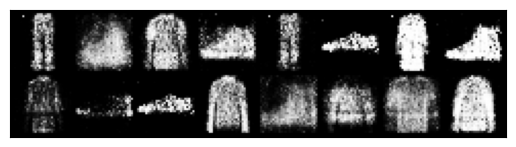

 13%|█▎        | 4/30 [03:08<19:38, 45.31s/it]

Epoch 4: |
                      Step: 3749 |
                      D_real Loss: 0.528 |
                      D_fake Loss: 0.483 |
                      D_total Loss: 1.010 |
                      G_Loss: 1.170 |
                      Real_score 0.662 |
                      Fake_score 0.368 |
                      Fake_score_after_D_update: 0.330
            


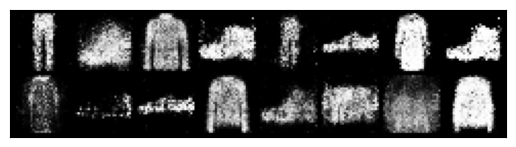

 17%|█▋        | 5/30 [03:51<18:35, 44.63s/it]

Epoch 5: |
                      Step: 3749 |
                      D_real Loss: 0.609 |
                      D_fake Loss: 0.495 |
                      D_total Loss: 1.104 |
                      G_Loss: 1.127 |
                      Real_score 0.619 |
                      Fake_score 0.371 |
                      Fake_score_after_D_update: 0.355
            


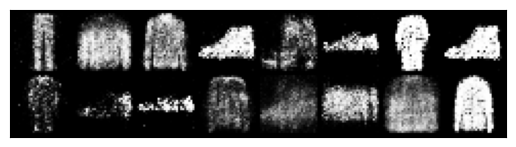

 20%|██        | 6/30 [04:33<17:30, 43.75s/it]

Epoch 6: |
                      Step: 3749 |
                      D_real Loss: 0.563 |
                      D_fake Loss: 0.711 |
                      D_total Loss: 1.274 |
                      G_Loss: 0.970 |
                      Real_score 0.623 |
                      Fake_score 0.472 |
                      Fake_score_after_D_update: 0.410
            


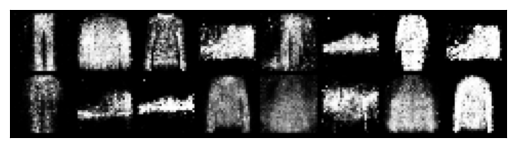

 23%|██▎       | 7/30 [05:18<16:52, 44.04s/it]

Epoch 7: |
                      Step: 3749 |
                      D_real Loss: 0.631 |
                      D_fake Loss: 0.583 |
                      D_total Loss: 1.214 |
                      G_Loss: 0.852 |
                      Real_score 0.554 |
                      Fake_score 0.432 |
                      Fake_score_after_D_update: 0.443
            


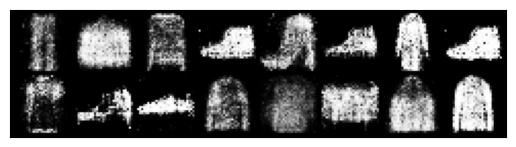

 27%|██▋       | 8/30 [06:03<16:14, 44.31s/it]

Epoch 8: |
                      Step: 3749 |
                      D_real Loss: 0.675 |
                      D_fake Loss: 0.705 |
                      D_total Loss: 1.380 |
                      G_Loss: 0.893 |
                      Real_score 0.534 |
                      Fake_score 0.476 |
                      Fake_score_after_D_update: 0.420
            


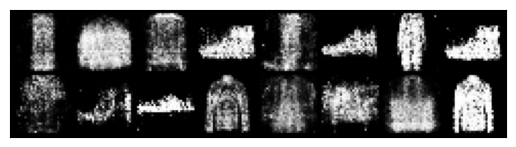

 30%|███       | 9/30 [06:47<15:29, 44.25s/it]

Epoch 9: |
                      Step: 3749 |
                      D_real Loss: 0.688 |
                      D_fake Loss: 0.758 |
                      D_total Loss: 1.445 |
                      G_Loss: 0.821 |
                      Real_score 0.522 |
                      Fake_score 0.504 |
                      Fake_score_after_D_update: 0.462
            


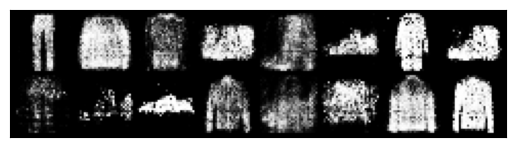

 33%|███▎      | 10/30 [07:31<14:42, 44.11s/it]

Epoch 10: |
                      Step: 3749 |
                      D_real Loss: 0.526 |
                      D_fake Loss: 0.558 |
                      D_total Loss: 1.084 |
                      G_Loss: 0.832 |
                      Real_score 0.621 |
                      Fake_score 0.417 |
                      Fake_score_after_D_update: 0.456
            


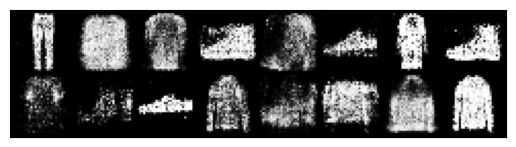

 37%|███▋      | 11/30 [08:15<14:01, 44.27s/it]

Epoch 11: |
                      Step: 3749 |
                      D_real Loss: 0.504 |
                      D_fake Loss: 0.611 |
                      D_total Loss: 1.115 |
                      G_Loss: 0.916 |
                      Real_score 0.632 |
                      Fake_score 0.444 |
                      Fake_score_after_D_update: 0.416
            


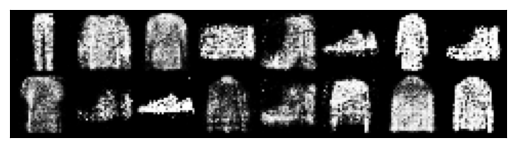

 40%|████      | 12/30 [09:00<13:18, 44.37s/it]

Epoch 12: |
                      Step: 3749 |
                      D_real Loss: 0.664 |
                      D_fake Loss: 0.806 |
                      D_total Loss: 1.471 |
                      G_Loss: 0.746 |
                      Real_score 0.549 |
                      Fake_score 0.524 |
                      Fake_score_after_D_update: 0.488
            


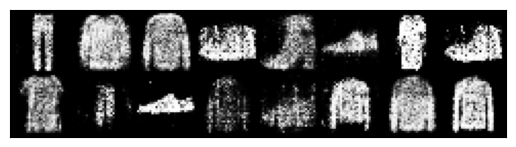

 43%|████▎     | 13/30 [09:45<12:36, 44.51s/it]

Epoch 13: |
                      Step: 3749 |
                      D_real Loss: 0.545 |
                      D_fake Loss: 0.682 |
                      D_total Loss: 1.227 |
                      G_Loss: 0.893 |
                      Real_score 0.598 |
                      Fake_score 0.482 |
                      Fake_score_after_D_update: 0.422
            


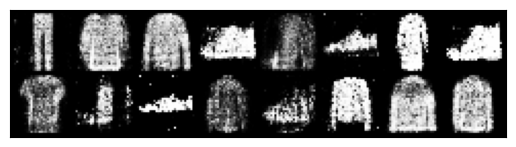

 47%|████▋     | 14/30 [10:31<11:59, 44.99s/it]

Epoch 14: |
                      Step: 3749 |
                      D_real Loss: 0.642 |
                      D_fake Loss: 0.714 |
                      D_total Loss: 1.355 |
                      G_Loss: 0.769 |
                      Real_score 0.546 |
                      Fake_score 0.498 |
                      Fake_score_after_D_update: 0.479
            


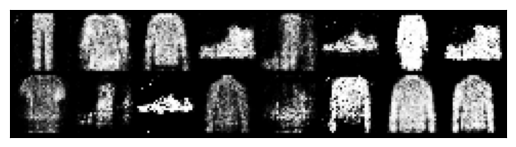

 50%|█████     | 15/30 [11:15<11:10, 44.67s/it]

Epoch 15: |
                      Step: 3749 |
                      D_real Loss: 0.654 |
                      D_fake Loss: 0.593 |
                      D_total Loss: 1.247 |
                      G_Loss: 0.859 |
                      Real_score 0.542 |
                      Fake_score 0.444 |
                      Fake_score_after_D_update: 0.430
            


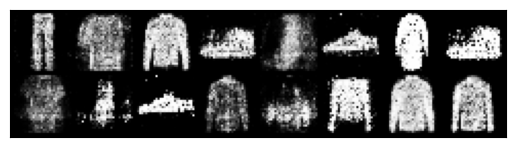

 53%|█████▎    | 16/30 [11:59<10:22, 44.45s/it]

Epoch 16: |
                      Step: 3749 |
                      D_real Loss: 0.685 |
                      D_fake Loss: 0.565 |
                      D_total Loss: 1.250 |
                      G_Loss: 0.863 |
                      Real_score 0.520 |
                      Fake_score 0.425 |
                      Fake_score_after_D_update: 0.436
            


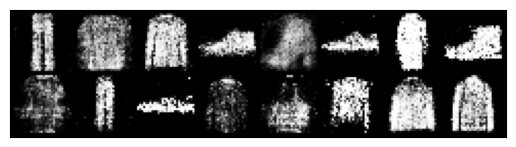

 57%|█████▋    | 17/30 [12:41<09:30, 43.91s/it]

Epoch 17: |
                      Step: 3749 |
                      D_real Loss: 0.777 |
                      D_fake Loss: 0.662 |
                      D_total Loss: 1.439 |
                      G_Loss: 0.765 |
                      Real_score 0.478 |
                      Fake_score 0.476 |
                      Fake_score_after_D_update: 0.482
            


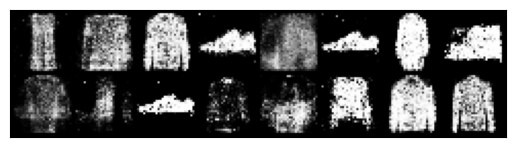

 60%|██████    | 18/30 [13:24<08:44, 43.72s/it]

Epoch 18: |
                      Step: 3749 |
                      D_real Loss: 0.811 |
                      D_fake Loss: 0.641 |
                      D_total Loss: 1.452 |
                      G_Loss: 0.828 |
                      Real_score 0.453 |
                      Fake_score 0.447 |
                      Fake_score_after_D_update: 0.448
            


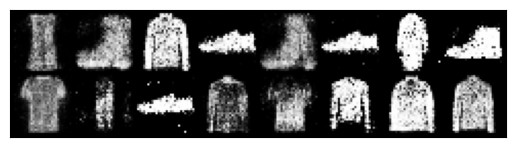

 63%|██████▎   | 19/30 [14:09<08:02, 43.84s/it]

Epoch 19: |
                      Step: 3749 |
                      D_real Loss: 0.788 |
                      D_fake Loss: 0.686 |
                      D_total Loss: 1.474 |
                      G_Loss: 0.842 |
                      Real_score 0.464 |
                      Fake_score 0.490 |
                      Fake_score_after_D_update: 0.435
            


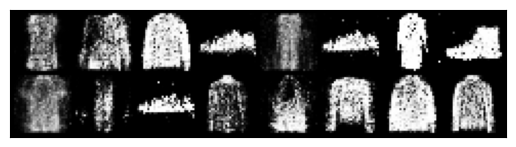

 67%|██████▋   | 20/30 [14:53<07:19, 43.99s/it]

Epoch 20: |
                      Step: 3749 |
                      D_real Loss: 0.718 |
                      D_fake Loss: 0.584 |
                      D_total Loss: 1.302 |
                      G_Loss: 0.929 |
                      Real_score 0.512 |
                      Fake_score 0.433 |
                      Fake_score_after_D_update: 0.403
            


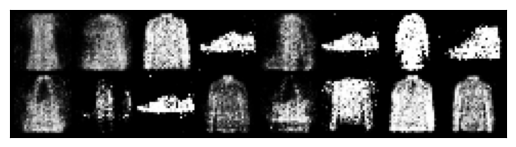

 70%|███████   | 21/30 [15:37<06:35, 43.98s/it]

Epoch 21: |
                      Step: 3749 |
                      D_real Loss: 0.718 |
                      D_fake Loss: 0.696 |
                      D_total Loss: 1.414 |
                      G_Loss: 0.698 |
                      Real_score 0.489 |
                      Fake_score 0.498 |
                      Fake_score_after_D_update: 0.501
            


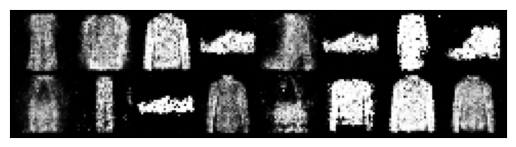

 73%|███████▎  | 22/30 [16:21<05:53, 44.14s/it]

Epoch 22: |
                      Step: 3749 |
                      D_real Loss: 0.683 |
                      D_fake Loss: 0.710 |
                      D_total Loss: 1.393 |
                      G_Loss: 0.817 |
                      Real_score 0.520 |
                      Fake_score 0.485 |
                      Fake_score_after_D_update: 0.446
            


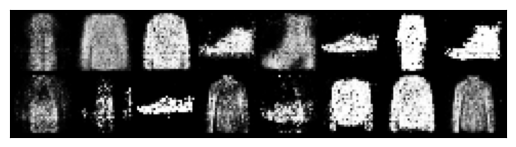

 77%|███████▋  | 23/30 [17:05<05:08, 44.04s/it]

Epoch 23: |
                      Step: 3749 |
                      D_real Loss: 0.634 |
                      D_fake Loss: 0.640 |
                      D_total Loss: 1.274 |
                      G_Loss: 0.792 |
                      Real_score 0.536 |
                      Fake_score 0.467 |
                      Fake_score_after_D_update: 0.457
            


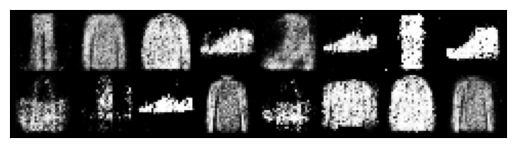

 80%|████████  | 24/30 [17:50<04:25, 44.33s/it]

Epoch 24: |
                      Step: 3749 |
                      D_real Loss: 0.625 |
                      D_fake Loss: 0.676 |
                      D_total Loss: 1.300 |
                      G_Loss: 0.831 |
                      Real_score 0.564 |
                      Fake_score 0.477 |
                      Fake_score_after_D_update: 0.446
            


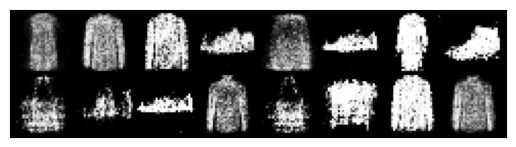

 83%|████████▎ | 25/30 [18:34<03:40, 44.20s/it]

Epoch 25: |
                      Step: 3749 |
                      D_real Loss: 0.674 |
                      D_fake Loss: 0.666 |
                      D_total Loss: 1.340 |
                      G_Loss: 0.819 |
                      Real_score 0.524 |
                      Fake_score 0.476 |
                      Fake_score_after_D_update: 0.450
            


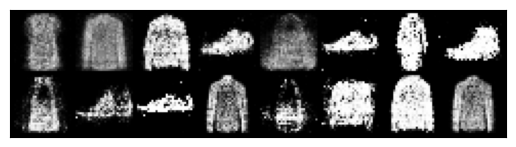

 87%|████████▋ | 26/30 [19:19<02:57, 44.31s/it]

Epoch 26: |
                      Step: 3749 |
                      D_real Loss: 0.716 |
                      D_fake Loss: 0.639 |
                      D_total Loss: 1.355 |
                      G_Loss: 0.771 |
                      Real_score 0.504 |
                      Fake_score 0.459 |
                      Fake_score_after_D_update: 0.475
            


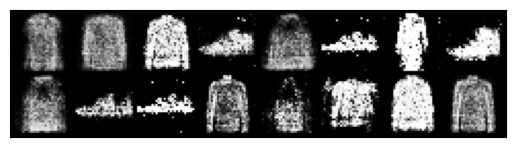

 90%|█████████ | 27/30 [20:03<02:12, 44.24s/it]

Epoch 27: |
                      Step: 3749 |
                      D_real Loss: 0.678 |
                      D_fake Loss: 0.685 |
                      D_total Loss: 1.362 |
                      G_Loss: 0.753 |
                      Real_score 0.513 |
                      Fake_score 0.487 |
                      Fake_score_after_D_update: 0.472
            


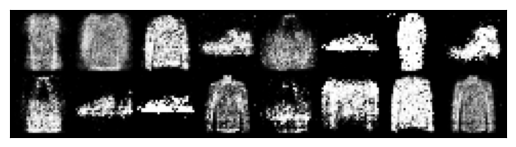

 93%|█████████▎| 28/30 [20:48<01:28, 44.41s/it]

Epoch 28: |
                      Step: 3749 |
                      D_real Loss: 0.607 |
                      D_fake Loss: 0.708 |
                      D_total Loss: 1.315 |
                      G_Loss: 0.716 |
                      Real_score 0.558 |
                      Fake_score 0.497 |
                      Fake_score_after_D_update: 0.496
            


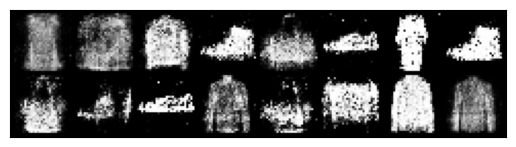

 97%|█████████▋| 29/30 [21:31<00:44, 44.21s/it]

Epoch 29: |
                      Step: 3749 |
                      D_real Loss: 0.697 |
                      D_fake Loss: 0.660 |
                      D_total Loss: 1.357 |
                      G_Loss: 0.718 |
                      Real_score 0.505 |
                      Fake_score 0.472 |
                      Fake_score_after_D_update: 0.496
            


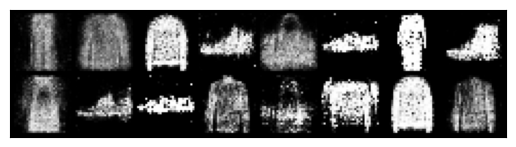

100%|██████████| 30/30 [22:16<00:00, 44.54s/it]


In [18]:
for epoch in tqdm(range(num_epochs)):

    G_losses = []
    D_losses = []

    real_score_list=[]
    fake_score_list=[]

    for i, data in enumerate(fmnist_dl, 0):
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad() # Clear the gradients of the discriminator network.

        # Reshape the real images to match the expected input shape of the discriminator.
        real_images = data[0].reshape(batch_size, 1, 784)

        # Create a tensor of real labels with the same batch size as the real images.
        real_labels = torch.full((batch_size,), real_label, dtype = torch.float)

        # Pass the real images through the discriminator and flatten the output.
        output = netD(real_images).view(-1)

        # Compute the discriminator loss on real images.
        errD_real = criterion(output, real_labels)

        # Backpropagate the loss for real images.
        errD_real.backward()

        # Calculate the mean score of the discriminator on real images.
        D_x = output.mean().item()

        # Generate fake image batch with G
        noise = torch.randn(batch_size, 100)

        # Create random noise to input to the generator.
        noise = torch.randn(batch_size, 100)

        # Generate fake images using the generator.
        fake_images = netG(noise)

        # Create a tensor of fake labels with the same batch size as the fake images.
        fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float)

        # Pass the fake images through the discriminator without calculating gradients for them.
        output = netD(fake_images.detach()).view(-1)

        # Compute the discriminator loss on fake images.
        errD_fake = criterion(output, fake_labels)

        # Backpropagate the loss for fake images.
        errD_fake.backward()

        # Calculate the mean score of the discriminator on fake images before updating the generator.
        D_G_z1 = output.mean().item()

        # Compute the total discriminator loss.
        errD = errD_real + errD_fake

        # Update the discriminator network parameters.
        d_optimizer.step()



        # (2) Update G network: maximize log(D(G(z)))
        netG.zero_grad() # Clear the gradients of the generator network.

        # Pass the generated fake images through the discriminator.
        output = netD(fake_images).view(-1)

        # Compute the generator loss based on the discriminator’s output.
        errG = criterion(output, real_labels)

        # Backpropagate the generator loss.
        errG.backward()

        # Calculate the mean score of the discriminator on fake images after updating the generator.
        D_G_z2 = output.mean().item()

        # Update the generator network parameters.
        g_optimizer.step()

        # Print the loss statistics and generated images every 200 steps or at the end of training.
        # if (i % 2000 == 0) or ((epoch == num_epochs-1) and (i == len(fmnist_dl) - 1)):
        if i == len(fmnist_dl) - 1:
            print(f"""Epoch {epoch+0:01}: |
                      Step: {i} |
                      D_real Loss: {errD_real:.3f} |
                      D_fake Loss: {errD_fake:.3f} |
                      D_total Loss: {errD:.3f} |
                      G_Loss: {errG:.3f} |
                      Real_score {D_x:.3f} |
                      Fake_score {D_G_z1:.3f} |
                      Fake_score_after_D_update: {D_G_z2:.3f}
            """)



            # View the output of the GAN every so often
            with torch.no_grad():
                fake_images = netG(fixed_noise).reshape(batch_size, 1, 28, 28).detach().cpu()
                display_image_grid(epoch, i, fake_images, nrow=8)

        G_losses.append(errG.item())
        D_losses.append(errD.item())
        real_score_list.append(D_x)
        fake_score_list.append(D_G_z1)


    avg_G_losses.append(np.mean(G_losses))
    avg_D_losses.append(np.mean(D_losses))
    avg_real_score_list.append(np.mean(real_score_list))
    avg_fake_score_list.append(np.mean(fake_score_list))

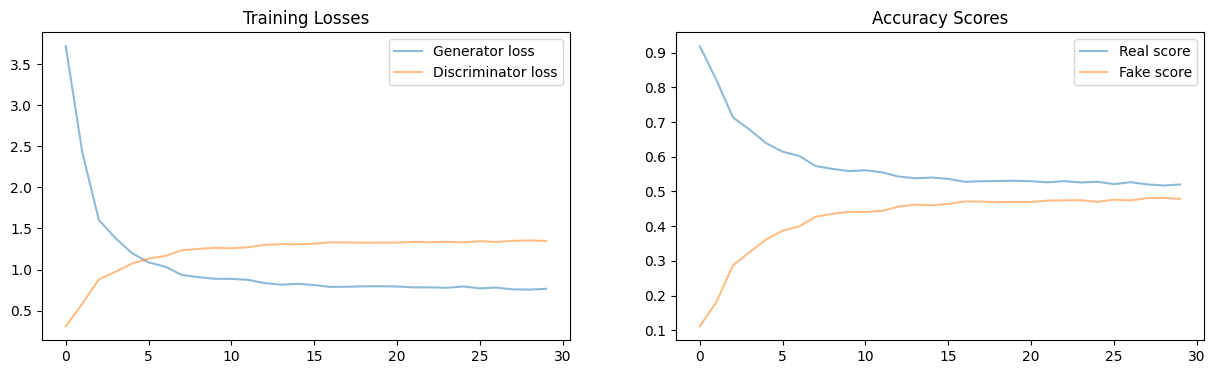

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 4))

ax1.plot(avg_G_losses, label = 'Generator loss', alpha = 0.5)
ax1.plot(avg_D_losses, label = 'Discriminator loss', alpha = 0.5)
ax1.legend()
ax1.set_title('Training Losses')

ax2.plot(avg_real_score_list, label = 'Real score', alpha = 0.5)
ax2.plot(avg_fake_score_list, label = 'Fake score', alpha = 0.5)
ax2.set_title('Accuracy Scores')

ax2.legend()